In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
sample_freq = 1e5  # in Hz
length = 15.0  # in s
noise_power = 5.0  # in dB

# create 'DopplerSignal' object
ds = ss.DopplerSignal(
    t_sec=length,  # length of signal in seconds
    f_sample=sample_freq,  # sample frequency after decimation
    f_carrier=450e6,  # frequency of signal before down sapling to baseband
    steps=int(1e3))  # steps / resolution

# get frequency and power vectors that contain the doppler shift
t, freq, signal_power = ds.get(
    f_center=-1e4,  # center frequency at half way point in Hz
    power=0.,  # power at half way point in dB ('peak' power)
    distance=6000.0,  # distance in m
    velocity=8000.0)  # velocity in m/s

# create the signal (the 'very_silent' kind) using the doppler shift vectors
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.very_silent(f_center=freq, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: -5.33 dB
Noise power:  5.01 dB
SNR:          -10.34 dB
Num samples:  1500000


In [4]:
# lets make a lot of bands so that we can see the signal
num_bands = 100

# wide band energy detector with 'fft_len' window length
fft_len = 512

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='box')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# create a Wideband Energy Detector object
fed = ss.WidebandEnergyDetector(num_bands=num_bands,
                                f_sample=sample_freq,
                                fft_len=fft_len,
                                freqs=f)

# compute the energy at every timestep
eng = np.asarray(list(map(fed.detect, x.T))).T

# # plot result of energy detector
# ss.util_wide.plot_matrix(eng, xlabel='Time / Num FFT', plabel='Energy')

In [5]:
# we set the probability of false alarm to our desired value
pfa = 0.001

# from that we calculate the threshold
thr = ss.chi2_stats.thr(noise_power=noise_power,
                        pfa=pfa,
                        n=fft_len // num_bands,
                        dB=True)

# and the probability of detection for 0dB signal power
pd = ss.chi2_stats.pd(noise_power=noise_power,
                      signal_power=0.,
                      thr=thr,
                      n=fft_len // num_bands,
                      dB=True,
                      num_bands=num_bands)

print('---- Stats theory ----')
print('Prob false alarm: %.5f' % (pfa))
print('Threshold:        %.5f' % (thr))
print('Prob detection:   %.5f' % (pd))

# apply threshold to result of energy detector matrix
res = (eng > thr) * np.full_like(eng, 1.)

# # plot the resulting binary decision matrix
# ss.util_wide.plot_matrix(res,
#                          xlabel='Time / Num FFT',
#                          plabel='Decision',
#                          binary=True)

---- Stats theory ----
Prob false alarm: 0.00100
Threshold:        46.78321
Prob detection:   0.99989


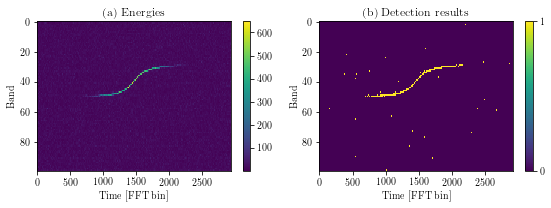

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.set_title(r'(a) Energies')
img = ax1.imshow(eng, aspect='auto')
ax1.set_xlabel(r'Time [FFT bin]')
ax1.set_ylabel(r'Band')
cbar = plt.colorbar(img, ax=ax1)
# cbar.set_label(r'Energy')

ax2.set_title(r'(b) Detection results')
img = ax2.imshow(res, aspect='auto')
ax2.set_xlabel(r'Time [FFT bin]')
ax2.set_ylabel(r'Band')
cbar = plt.colorbar(img, ax=ax2)
# cbar.set_label(r'Decision')
cbar.set_ticks([0, 1])

plt.tight_layout()
plt.savefig('out/chap5/wideband_detect_doppler.pdf')